# Grid search forecaster

Skforecast library combines grid search strategy with backtesting to identify the combination of lags and hyperparameters that achieve the best prediction performance.

The grid search requires two grids, one with the different lags configuration (`lags_grid`) and the other with the list of hyperparameters to be tested (`param_grid`). The process comprises the following steps:

1. `grid_search_forecaster` creates a copy of the forecaster object and replaces the `lags` argument with the first option appearing in `lags_grid`.

2. The function validates all combinations of hyperparameters presented in `param_grid` by [backtesting](https://joaquinamatrodrigo.github.io/skforecast/latest/notebooks/backtesting.html).

3. The function repeats these two steps until it runs through all the possibilities (lags + hyperparameters).

4. If `return_best = True`, the original forecaster is trained with the best lags and hyperparameters configuration found.

## Libraries

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from sklearn.metrics import mean_squared_error

## Data

Train dates      : 1991-07-01 00:00:00 --- 2001-01-01 00:00:00  (n=115)
Validation dates : 2001-02-01 00:00:00 --- 2006-01-01 00:00:00  (n=60)
Test dates       : 2006-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=29)


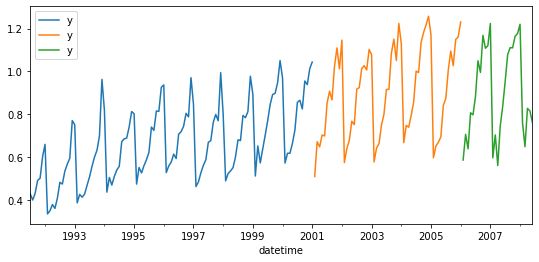

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()

# Train-val-test dates
# ==============================================================================
end_train = '2001-01-01 23:59:00'
end_val = '2006-01-01 23:59:00'

print(f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}  (n={len(data.loc[:end_train])})")
print(f"Validation dates : {data.loc[end_train:].index.min()} --- {data.loc[:end_val].index.max()}  (n={len(data.loc[end_train:end_val])})")
print(f"Test dates       : {data.loc[end_val:].index.min()} --- {data.index.max()}  (n={len(data.loc[end_val:])})")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:end_val].plot(ax=ax, label='validation')
data.loc[end_val:].plot(ax=ax, label='test')
ax.legend();

## Grid search with time series cross-validation

In [3]:
# Grid search hyperparameter and lags
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:end_val, 'y'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 12,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 18


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:15<00:00,  5.11s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.03344857370906804



In [4]:
results_grid

,lags,params,metric,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 50}",0.033449,5,50
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 50}",0.039221,10,50
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 100}",0.039266,15,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",0.039526,5,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",0.040241,10,100
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 15, 'n_estimators': 50}",0.040765,15,50
17,"[1, 2, 3, 20]","{'max_depth': 15, 'n_estimators': 100}",0.043909,15,100
13,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 100}",0.044992,5,100
12,"[1, 2, 3, 20]","{'max_depth': 5, 'n_estimators': 50}",0.046224,5,50
0,"[1, 2, 3]","{'max_depth': 5, 'n_estimators': 50}",0.048666,5,50


In [5]:
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=5, n_estimators=50, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Window size: 10 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2006-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-03-26 17:52:42 
Last fit date: 2022-03-26 17:52:57 
Skforecast version: 0.4.3 

## Grid search with custom metric

Besides the frequently used metrics: mean_squared_error, mean_absolute_error, and mean_absolute_percentage_error, it is possible to use any custom function as long as:

+ It includes the arguments:

    + `y_true`: true values of the series.

    + `y_pred`: predicted values.

+ It returns a numeric value (`float` or `int`).

It allows evaluating the predictive capability of the model in a wide range of scenarios, for example:

+ Consider only certain months, days, hours...

+ Consider only dates that are holidays.

+ Consider only the last step of the predicted horizon.

The following example shows how to forecast a 12-month horizon but considering only the last 3 months of each year to calculate the interest metric.

In [6]:
# Grid search hyperparameter and lags with custom metric
# ==============================================================================
def custom_metric(y_true, y_pred):
    '''
    Calculate the mean squared error using only the predicted values of the last
    3 months of the year.
    '''
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_squared_error(y_true[mask], y_pred[mask])
    
    return metric
    
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 10 # Placeholder, the value will be overwritten
             )

# Lags used as predictors
lags_grid = [3, 10, [1, 2, 3, 20]]

# Regressor hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [5, 10, 15]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data.loc[:end_val, 'y'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 12,
                        refit       = True,
                        metric      = custom_metric,
                        initial_train_size = len(data.loc[:end_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
               )

Number of models compared: 18


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:12<00:00,  4.30s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.04867459231626605



In [7]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>